<a href="https://colab.research.google.com/github/dbenayoun/IASD/blob/main/ProjetIA/Copie_de_Adversarial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from random import random

cuda = torch.cuda.is_available()

## From adversarial examples to training robust models

In the previous notebooks, we focused on methods for solving the maximization problem over perturbations; that is, to finding the solution to the problem
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}

In this notebook, we will focus on training a robust classifier. More precisly, we aim at solving following minimization problem, namely Adversarial Training:
\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_\theta \frac{1}{|S|} \sum_{x,y \in S} \max_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}
The order of the min-max operations is important here.  Specially, the max is inside the minimization, meaning that the adversary (trying to maximize the loss) gets to "move" _second_.  We assume, essentially, that the adversary has full knowledge of the classifier parameters $\theta$, and that they get to specialize their attack to whatever parameters we have chosen in the outer minimization. The goal of the robust optimization formulation, therefore, is to ensure that the model cannot be attacked _even if_ the adversary has full knowledge of the model.  Of course, in practice we may want to make assumptions about the power of the adversary but it can be difficult to pin down a precise definition of what we mean by the "power" of the adversary, so extra care should be taken in evaluating models against possible "realistic" adversaries.

# Fucntions
1. Train a robust classifier using Adversarial Training with a specific norm
2. Evaluate your classifier on natural and adversarial examples crafted with the norm of the training and other norms
3. Make an analysis and conclude

In [2]:
# load CIFAR10 dataset
def load_cifar(split, batch_size):
  train = True if split == 'train' else False
  dataset = datasets.CIFAR10("./docs", train=split, download=True, transform=transforms.ToTensor())
  return DataLoader(dataset, batch_size=batch_size, shuffle=train)

cifar10_classes = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

batch_size = 100
train_loader = load_cifar('train', batch_size)
test_loader = load_cifar('test', batch_size)



100%|██████████| 170M/170M [00:04<00:00, 42.3MB/s]


Extracting ./docs/cifar-10-python.tar.gz to ./docs
Files already downloaded and verified


In [3]:
class ConvModel(torch.nn.Module):

  def __init__(self):
    super(ConvModel, self).__init__()
    # First Convolutional Layer: Input channels = 3, Output channels = 32
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    # First Max Pooling Layer: Reduces each dimension by a factor of 2
    self.pool1 = nn.MaxPool2d(kernel_size=2)

    # Second Convolutional Layer: Input channels = 32, Output channels = 64
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    # Second Max Pooling Layer: Reduces each dimension by a factor of 2
    self.pool2 = nn.MaxPool2d(kernel_size=2)

    self.fc1 = nn.Linear(64 * 8 * 8, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10)  # Assuming 10 output classes


  def forward(self, x):
    # First convolutional block: Conv -> ReLU -> MaxPool
    x = self.pool1(nn.functional.relu(self.conv1(x)))
    # Second convolutional block: Conv -> ReLU -> MaxPool
    x = self.pool2(nn.functional.relu(self.conv2(x)))

    # Flatten the output for the fully connected layers
    x = x.view(-1, 64 * 8 * 8)  # Flattening the output from conv layers

    # First fully connected block: FC -> ReLU
    x = nn.functional.relu(self.fc1(x))
    # Second fully connected block: FC -> ReLU
    x = nn.functional.relu(self.fc2(x))
    # Output layer: FC
    x = self.fc3(x)

    return x

In [39]:
class FastGradientSignMethod:

  def __init__(self, model, eps):
    self.model = model
    self.eps = eps


  def compute(self, x, y):
    """ Construct FGSM adversarial perturbation for examples x"""
    delta = torch.zeros_like(x, requires_grad=True)
    # code here ...
    criterion = nn.CrossEntropyLoss()
    output = self.model(x + delta)
    loss = criterion(output, y)
    loss.backward()
    # Use variable.grad.detach() to retreive the gradient with respect to a loss
    grad = delta.grad.detach()
    delta = self.eps * grad.sign()

    return delta


class ProjectedGradientDescent:

  def __init__(self, model, eps, alpha, num_iter):
    self.model = model
    self.eps = eps
    self.alpha = alpha
    self.num_iter = num_iter

  def compute(self, x, y):
    """ Construct PGD adversarial pertubration on the examples x."""
    # delta = torch.randn_like(x, requires_grad=True)
    delta = torch.zeros_like(x, requires_grad=True)
    for t in range(self.num_iter):
      adv = torch.clamp(x + delta, 0, 1)
      loss = nn.CrossEntropyLoss()(self.model(adv), y)
      loss.backward()
      delta.data = (delta.data + self.alpha * delta.grad.sign()).clamp(-self.eps, self.eps)
      delta.grad.zero_()
    return delta.detach()


class ProjectedGradientDescentL2:

    def __init__(self, model, eps, alpha, num_iter):
        self.model = model
        self.eps = eps
        self.alpha = alpha
        self.num_iter = num_iter

    def compute(self, x, y):
        delta = torch.zeros_like(x, requires_grad=True)
        for t in range(self.num_iter):
            adv = x + delta
            adv = torch.clamp(adv, 0, 1)  # Ensure the values are in [0,1]
            loss = nn.CrossEntropyLoss()(self.model(adv), y)
            loss.backward()
            grad_norm = delta.grad.detach().norm(2)
            normalized_grad = delta.grad.detach() / (grad_norm + 1e-10)
            delta.data += self.alpha * normalized_grad
            delta.data = torch.renorm(delta.detach(), p=2, dim=0, maxnorm=self.eps)
            delta.grad.zero_()
        return delta.detach()

class ProjectedGradientDescentLinfinity:

    def __init__(self, model, eps, alpha, num_iter):
        self.model = model
        self.eps = eps  # Maximum allowed perturbation
        self.alpha = alpha  # Step size for each iteration
        self.num_iter = num_iter  # Number of iterations

    def compute(self, x, y):
        delta = torch.zeros_like(x, requires_grad=True)  # Initialize perturbation

        for t in range(self.num_iter):
            adv = x + delta  # Add perturbation to input
            adv = torch.clamp(adv, 0, 1)  # Ensure the values are in [0, 1]

            loss = nn.CrossEntropyLoss()(self.model(adv), y)  # Calculate loss
            loss.backward()  # Compute gradients

            # Normalize the gradients using L_inf
            delta.data += self.alpha * torch.sign(delta.grad.detach())  # Take sign of gradient for L_inf
            delta.data = torch.clamp(delta.data, -self.eps, self.eps)  # Project delta to be within [-eps, eps]

            delta.grad.zero_()  # Reset the gradients for the next iteration

        return delta.detach()  # Return the final perturbation


In [5]:
def adversarial_train_model(model, criterion, optimizer, loader, epochs=5, attack=None, perc_attacked=1, verbose=True):
  """Function to train the model"""

  f = 0
  train_losses = []
  for e in range(epochs):
    for batch_idx, (images, labels) in enumerate(train_loader):
        if cuda:
          images, labels = images.cuda(), labels.cuda()
        f = f + 1
        model.train() # - Set the model to train mode
        optimizer.zero_grad()# - Reset the optimizer

        if attack is None:
          output = model(images)
        else:
          if random() < perc_attacked:
            delta = attack.compute(images, labels)
            output = model(images + delta)
          else:
            output = model(images)

        loss = criterion(output, labels)# - Compute the loss
        loss.backward()# - Backward pass
        optimizer.step()# - Update the weights
    if verbose:
      print('Epoch: {} \tTraining Loss: {:.6f}'.format(e+1, loss.item()))
    train_losses.append(loss.item()) #save loss

  return train_losses


In [48]:
def eval_model(model, loader, attack=None, attack_name=''):
  """Function to evaluate your model on a specific loader"""
  accuracy = 0.
  n_inputs = 0.
  for n_batch, (imgs, labels) in enumerate(loader):
    if cuda:
      imgs, labels = imgs.cuda(), labels.cuda()
    if attack is None:
      outputs = model(imgs)
    else:
      delta = attack.compute(imgs, labels)
      adv = imgs + delta
      outputs = model(adv)
    _, predicted = torch.max(outputs.data, 1)
    accuracy += predicted.eq(labels.data).cpu().sum().numpy()
    n_inputs += imgs.shape[0]
  accuracy /= n_inputs

  if attack is None:
    print('Clean Accuracy, accuracy on testset: {:.4f}'.format(accuracy))
  else:
    print('Robust Accuracy, accuracy on testset with attack {}: {:.4f}'.format(attack_name, accuracy))



# Test attack

In [9]:
def plot_images(x, y, yp, M=5, N=5):
  x = x.cpu().numpy()
  y = y.cpu().numpy()
  f, ax = plt.subplots(M, N, sharex=True, sharey=True, figsize=(N*2, M*1.3))
  for i in range(M):
    for j in range(N):
      img = x[i*N+j].transpose(1, 2, 0)
      img = np.maximum(0, np.minimum(img, 1))
      ax[i][j].imshow(img)
      title = ax[i][j].set_title("Pred: {}".format(cifar10_classes[int(yp[i*N+j].max(dim=0)[1])]))
      plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
      ax[i][j].set_axis_off()
    plt.tight_layout()
  plt.show()

for imgs, labels in test_loader:
  if cuda:
    imgs, labels = imgs.cuda(), labels.cuda()
  break

# PLAN  - Adversarial Attacks on CIFAR-10: Robustness and Tradeoffs

## 1. Initial Analysis: Training Robust Models and Accuracy Tradeoff

### A. Training Strategies for Robustness
- **Standard Training**
  - Description of the ConvModel architecture
  - Training on clean CIFAR-10 dataset
- **Adversarial Training**
  - Incorporation of adversarial examples (FGSM, PGD, PGD\_l2) during training
  - Training process and parameters
- **Defense Mechanisms**
  - Implementation of additional defenses (e.g., gradient masking, regularization techniques)
  - Evaluation of their effectiveness

### B. Evaluating Robustness vs. Accuracy Tradeoff
- **Metrics to Consider**
  - Clean Accuracy: Performance on unaltered test set
  - Robust Accuracy: Performance on adversarially perturbed test set
- **Tradeoff Insights**
  - Analysis of how adversarial training affects clean and robust accuracy
  - Comparison of different adversarial training methods
- **Visualization**
  - Graphs plotting clean vs. robust accuracy for various training strategies
- **Statistical Analysis**
  - Statistical significance of observed tradeoffs
  - Discussion on reasons behind the tradeoff

## 2. Elaboration Topic: Transferability of Adversarial Attacks

### A. Understanding Transferability
- **Definition**
  - Explanation of transferability in the context of adversarial attacks
- **Mechanisms**
  - How adversarial examples crafted for one model can affect others

### B. Importance of Studying Transferability
- **Black-Box Attacks**
  - Utilization of transferability for attacks without access to target model parameters
- **Robustness Implications**
  - Impact on the general robustness of different models
- **Security Considerations**
  - Implications for the security of deployed machine learning systems

### C. Experimental Approach
- **Multiple Models**
  - Training diverse ConvModels with varying architectures and hyperparameters
  - Inclusion of models with different adversarial training methods
- **Generating Adversarial Examples**
  - Creation of adversarial examples using FGSM, PGD, and PGD\_l2 on source models
  - Testing these examples on target models to assess transferability
- **Metrics**
  - Transfer Success Rate: Percentage of adversarial examples deceiving target models
  - Robust Accuracy Across Models: Measuring general robustness
- **Factors Influencing Transferability**
  - Model Similarity: Impact of architectural similarities
  - Training Methods: Effect of different defense strategies
  - Attack Strength: Role of perturbation magnitude in transferability

# Adversarial Attacks on CIFAR-10: Robustness and Tradeoffs


## 1. Initial Analysis: Training Robust Models and Accuracy Tradeoff


### A. Training Strategies for Robustness

#### **Standard Training**

In [8]:
print('Model without attack:')
# adverserial training with PGD
model_noattack = ConvModel()
if cuda:
  model_noattack = model_noattack.cuda()
# define your loss
criterion = nn.CrossEntropyLoss()
# define the optimizer
opt = optim.Adam(model_noattack.parameters(), lr=0.001)
#define attack
attack = None
#define % attacked of the train dataset
perc_attacked = 1
# define epoch
epochs = 20

train_losses = adversarial_train_model(model_noattack, criterion, opt, train_loader, epochs, attack, perc_attacked, verbose=True)

Model without attack:
Epoch: 1 	Training Loss: 1.335442
Epoch: 2 	Training Loss: 1.287649
Epoch: 3 	Training Loss: 1.054243
Epoch: 4 	Training Loss: 0.864153
Epoch: 5 	Training Loss: 0.833491
Epoch: 6 	Training Loss: 1.070871
Epoch: 7 	Training Loss: 0.822135
Epoch: 8 	Training Loss: 0.751014
Epoch: 9 	Training Loss: 0.622844
Epoch: 10 	Training Loss: 0.696996
Epoch: 11 	Training Loss: 0.490263
Epoch: 12 	Training Loss: 0.458584
Epoch: 13 	Training Loss: 0.384226
Epoch: 14 	Training Loss: 0.396722
Epoch: 15 	Training Loss: 0.309745
Epoch: 16 	Training Loss: 0.439810
Epoch: 17 	Training Loss: 0.251281
Epoch: 18 	Training Loss: 0.256578
Epoch: 19 	Training Loss: 0.232607
Epoch: 20 	Training Loss: 0.388094


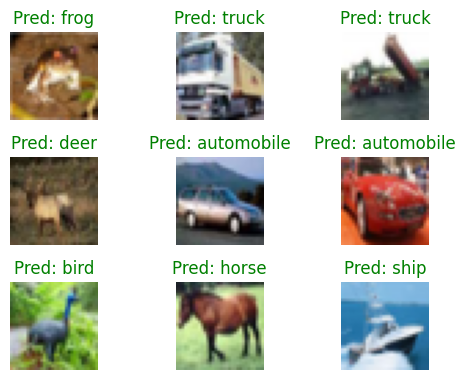

In [10]:
# plot natural images
output = model_noattack(imgs)
plot_images(imgs, labels, output, 3, 3)

In [58]:
fgsm = FastGradientSignMethod(model_noattack, 0.1)
pdg_l0 = ProjectedGradientDescent(model_noattack, eps=0.03, alpha=0.006, num_iter=10)
pdg_l2 = ProjectedGradientDescentL2(model_noattack, eps=0.03, alpha=0.006, num_iter=40)
pdg_linf = ProjectedGradientDescentLinfinity(model_noattack, 0.1, 0.001, 10)


In [59]:
#Clean Accuracy: eval model on not attacked test set
#eval_model(model_noattack, test_loader)
#Robust Accuracy: eval model attacked test set
#eval_model(model_noattack, test_loader, fgsm, 'FGSM')
#eval_model(model_noattack, test_loader, pdg_l0, 'PGD L0')
eval_model(model_noattack, test_loader, pdg_l2, 'PGD L2')
#eval_model(model_noattack, test_loader, pdg_linf, 'PGD Linf')

Robust Accuracy, accuracy on testset with attack PGD L2: 0.9007


#### **Adversarial Training**

1. FGSM

In [62]:
print('Model with attack FGSM:')
# adverserial training with PGD
model_withattackFGSM = ConvModel()
if cuda:
  model_withattack = model_withattackFGSM.cuda()
# define your loss
criterion = nn.CrossEntropyLoss()
# define the optimizer
opt = optim.Adam(model_withattackFGSM.parameters(), lr=0.01)
#define attack
eps = 0.1
fgsm = FastGradientSignMethod(model_noattack, eps)
#define % attacked of the train dataset
perc_attacked = 1
# define epoch
epochs = 20

train_losses = adversarial_train_model(model_withattackFGSM, criterion, opt, train_loader, epochs,
                                       attack=fgsm, perc_attacked=perc_attacked, verbose=True)

Model with attack FGSM:
Epoch: 1 	Training Loss: 0.968897
Epoch: 2 	Training Loss: 0.506582
Epoch: 3 	Training Loss: 0.571578
Epoch: 4 	Training Loss: 0.480158
Epoch: 5 	Training Loss: 0.397141
Epoch: 6 	Training Loss: 0.469069
Epoch: 7 	Training Loss: 0.400380
Epoch: 8 	Training Loss: 0.228748


KeyboardInterrupt: 

Classification non attacked img of a standard training


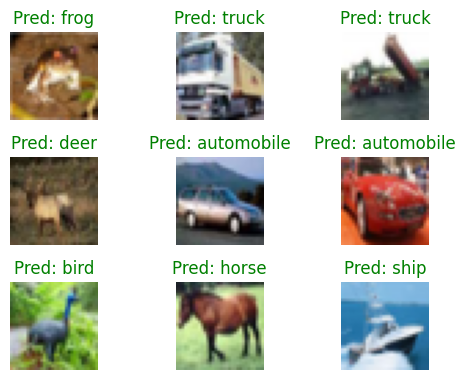

Classification with attacked img of a standard training


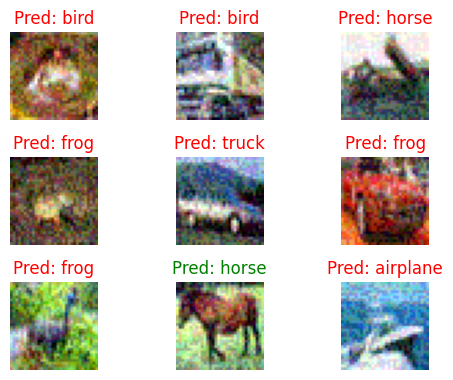

Classification with attacked img of an adversarial training


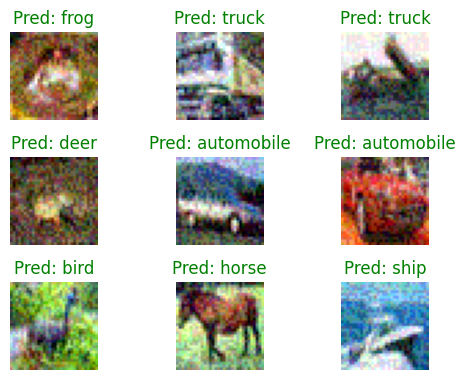

In [ ]:
# plot natural images
delta = fgsm.compute(imgs, labels)
print("Classification with attacked img of a standard training")
plot_images(imgs+delta, labels, model_noattack(imgs+delta), M=3, N=3)
print("Classification with attacked img of an adversarial training")
plot_images(imgs+delta, labels, model_withattackFGSM(imgs+delta), M=3, N=3)

In [60]:
eval_model(model_withattackFGSM, test_loader, fgsm, 'FGSM')


NameError: name 'model_withattackFGSM' is not defined

2. PGB L0

When using PGD for adversarial training, it's normal for the model to struggle with convergence compared to FGSM or standard training. This is because PGD generates stronger, more challenging adversarial examples through iterative optimization, making the training harder. PGD requires more careful tuning of hyperparameters like learning rate and attack step size. To help, consider adjusting the learning rate, experimenting with different PGD parameters, or using a mix of FGSM and PGD in the early stages of training.

In [64]:
print('Model with attack PGD L0:')
# adverserial training with PGD
model_withattackPGD = ConvModel()
if cuda:
  model_withattackPGD = model_withattackPGD.cuda()
# define your loss
criterion = nn.CrossEntropyLoss()
# define the optimizer
opt = optim.Adam(model_withattackPGD.parameters(), lr=0.001)
#define attack
pdg_l0 = ProjectedGradientDescent(model_noattack, eps=0.03, alpha=0.006, num_iter=10)
#define % attacked of the train dataset
perc_attacked = 1
# define epoch
epochs = 10

train_losses = adversarial_train_model(model_withattackPGD, criterion, opt, train_loader, epochs, attack=pdg_l0, perc_attacked=perc_attacked, verbose=True)

Model with attack PGD L0:
Epoch: 1 	Training Loss: 1.393952
Epoch: 2 	Training Loss: 1.298543
Epoch: 3 	Training Loss: 1.056141
Epoch: 4 	Training Loss: 0.935610
Epoch: 5 	Training Loss: 0.720246
Epoch: 6 	Training Loss: 0.515669
Epoch: 7 	Training Loss: 0.596540
Epoch: 8 	Training Loss: 0.379364
Epoch: 9 	Training Loss: 0.282359
Epoch: 10 	Training Loss: 0.271279


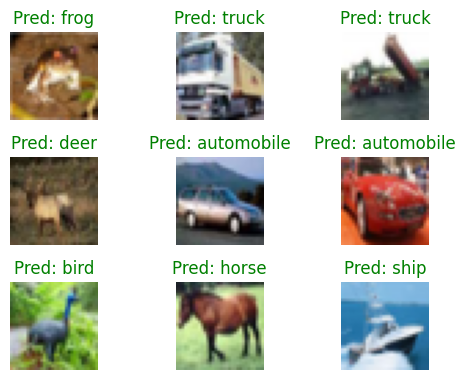

Classification with attacked img of a standard training


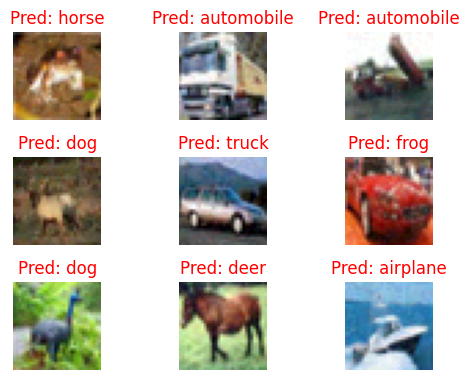

Classification with attacked img of an adversarial training


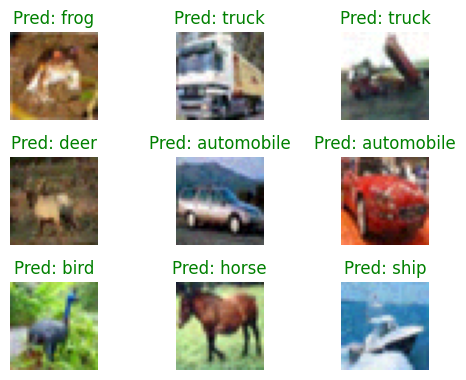

In [66]:
# plot natural images
delta = pdg_l0.compute(imgs, labels)
#print("Classification non attacked img of a standard training")
#plot_images(imgs, labels, model_noattack(imgs),M=3, N=3)
print("Classification with attacked img of a standard training")
plot_images(imgs+delta, labels, model_noattack(imgs+delta), M=3, N=3)
print("Classification with attacked img of an adversarial training")
plot_images(imgs+delta, labels, model_withattackPGD(imgs+delta), M=3, N=3)

In [67]:
eval_model(model_withattackFGSM, test_loader, pdg_l0, 'PGD L0')


Robust Accuracy, accuracy on testset with attack PGD L0: 0.5910


3. PGD L2

In [68]:
print('Model with attack PGD L2:')
# adverserial training with PGD
model_withattackPGDL2 = ConvModel()
if cuda:
  model_withattack = model_withattackPGDL2.cuda()
# define your loss
criterion = nn.CrossEntropyLoss()
# define the optimizer
opt = optim.Adam(model_withattackPGDL2.parameters(), lr=0.001)
#define attack
eps = 0.1
pdg_l2 = ProjectedGradientDescentL2(model_noattack, eps=0.03, alpha=0.006, num_iter=10)
#define % attacked of the train dataset
perc_attacked = 1
# define epoch
epochs = 10

train_losses = adversarial_train_model(model_withattackPGDL2, criterion, opt, train_loader, epochs, attack=pdg_l2, perc_attacked=perc_attacked, verbose=True)

Model with attack PGD L2:
Epoch: 1 	Training Loss: 1.260516
Epoch: 2 	Training Loss: 1.198880
Epoch: 3 	Training Loss: 1.117623
Epoch: 4 	Training Loss: 0.810985
Epoch: 5 	Training Loss: 0.638660
Epoch: 6 	Training Loss: 0.854516
Epoch: 7 	Training Loss: 0.866179
Epoch: 8 	Training Loss: 0.751480
Epoch: 9 	Training Loss: 0.736170
Epoch: 10 	Training Loss: 0.484882


Classification with attacked img of a standard training


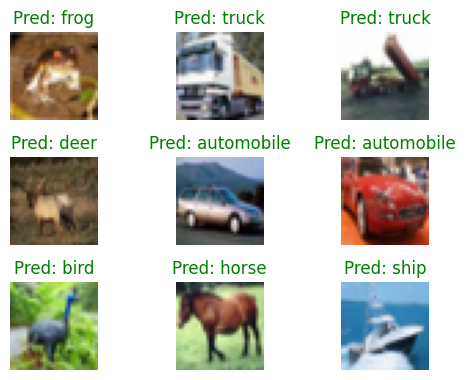

Classification with attacked img of an adversarial training


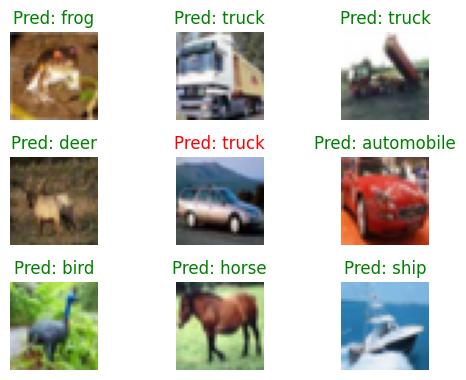

In [69]:
# plot natural images
delta = pdg_l2.compute(imgs, labels)
#print("Classification non attacked img of a standard training")
#plot_images(imgs, labels, model_noattack(imgs),M=3, N=3)
print("Classification with attacked img of a standard training")
plot_images(imgs+delta, labels, model_noattack(imgs+delta), M=3, N=3)
print("Classification with attacked img of an adversarial training")
plot_images(imgs+delta, labels, model_withattackPGD(imgs+delta), M=3, N=3)

4. PGD Linf


In [ ]:
print('Model with attack PGD Linf:')
# adverserial training with PGD
model_withattackPGDLinf = ConvModel()
if cuda:
  model_withattack = model_withattackPGDLinf.cuda()
# define your loss
criterion = nn.CrossEntropyLoss()
# define the optimizer
opt = optim.Adam(model_withattackPGDLinf.parameters(), lr=0.001)
#define attack
eps = 0.1
pdg_linf = ProjectedGradientDescentLinfinity(model_withattackPGDLinf, 0.1, 0.001, 2)
#define % attacked of the train dataset
perc_attacked = 1
# define epoch
epochs = 5

train_losses = adversarial_train_model(model_withattackPGDLinf, criterion, opt, train_loader, epochs, attack=pdg_linf, perc_attacked=perc_attacked, verbose=True)

Model with attack PGD Linf:
Epoch: 1 	Training Loss: 1.389466
Epoch: 2 	Training Loss: 1.487089
Epoch: 3 	Training Loss: 1.142921
Epoch: 4 	Training Loss: 1.002026
Epoch: 5 	Training Loss: 1.148413


### B. Evaluating Robustness vs. Accuracy Tradeoff

**Metrics to Consider**

**Tradeoff Insights**

1. On model without adversarial training

In [ ]:
#Clean Accuracy: eval model on not attacked test set
eval_model(model_noattack, test_loader)
#Robust Accuracy: eval model attacked test set
eval_model(model_noattack, test_loader, fgsm, 'FGSM')
eval_model(model_noattack, test_loader, pdg_l0, 'PGD L0')
eval_model(model_noattack, test_loader, pdg_l2, 'PGD L2')
eval_model(model_noattack, test_loader, pdg_linf, 'PGD Linf')

Clean Accuracy, accuracy on testset: 0.7300
Robust Accuracy, accuracy on testset with attack FGSM: 0.0992
Robust Accuracy, accuracy on testset with attack PGD L0: 0.6977
Robust Accuracy, accuracy on testset with attack PGD L2: 0.6972
Robust Accuracy, accuracy on testset with attack PGD Linf: 0.6974


2. On model with adversarial dedicated adversarial training

In [ ]:
#Clean Accuracy: eval model on not attacked test set
eval_model(model_withattackFGSM, test_loader)
eval_model(model_withattackPGD, test_loader)
eval_model(model_withattackPGDL2, test_loader)
eval_model(model_withattackPGDLinf, test_loader)

#Robust Accuracy: eval model attacked test set
eval_model(model_withattackFGSM, test_loader, fgsm, 'FGSM')
eval_model(model_withattackPGD, test_loader, pdg_l0, 'PGD L0')
eval_model(model_withattackPGDL2, test_loader, pdg_l2, 'PGD L2')
eval_model(model_withattackPGDLinf, test_loader, pdg_linf, 'PGD Linf')

Clean Accuracy, accuracy on testset: 0.6012
Clean Accuracy, accuracy on testset: 0.7306
Clean Accuracy, accuracy on testset: 0.7221
Clean Accuracy, accuracy on testset: 0.7102
Robust Accuracy, accuracy on testset with attack FGSM: 0.8686
Robust Accuracy, accuracy on testset with attack PGD L0: 0.6638
Robust Accuracy, accuracy on testset with attack PGD L2: 0.6500
Robust Accuracy, accuracy on testset with attack PGD Linf: 0.6433
